Voici un rapport sous forme de Jupyter Notebook qui décrit en détail le processus de segmentation des clients pour Olist, en utilisant différentes techniques de clustering. Ce rapport inclut l'analyse des résultats ainsi que des explications sur chaque modèle et méthode statistique utilisée. Ce rapport est construit de manière progressive, en enchaînant les codes et les analyses.

# Sommaire <a name=0 ></a>
- [Introduction](#1)
- [I. Segmentation par K-Means](#2)
    - [1. Méthode du Coude](#3)
    - [2. Silhouette Score](#4)
    - [3. Stabilité des Clusters](#5)
    - [4. Caractéristiques des Clusters](#6)
- [II. Segmentation par Agglomerative Clustering](#7)
    - [1. Calcul de l'Inertie](#8)
    - [2. Caractéristiques des Clusters](#9)
- [III. Segmentation par DBSCAN](#10)
- [IV. Analyse des Segments](#11)
    - [1. Distribution des Variables par Cluster KMeans](#12)
    - [2. Répartition & Chiffre d'Affaires](#13)
- [Conclusion](#14)

# Introduction<a name=1 ></a>

Dans un environnement commercial de plus en plus compétitif, comprendre les besoins et comportements des clients est essentiel pour toute entreprise souhaitant optimiser ses opérations et maximiser sa rentabilité. La segmentation des clients est une approche stratégique qui permet de diviser une base de clients en groupes distincts, chacun avec des caractéristiques similaires. Ces segments permettent de personnaliser les actions marketing, d'améliorer l'expérience client et d'optimiser les processus opérationnels.

Ce rapport propose une méthodologie complète pour segmenter les clients de la plateforme Olist à l'aide de techniques de clustering, en se basant sur des données historiques. Trois modèles de clustering seront utilisés pour explorer et identifier des segments pertinents parmi les clients : K-Means, Agglomerative Clustering et DBSCAN. Nous commencerons par importer de nouveau notre dataset en procédant à la même méthode que dans le notebook précédent. Après quoi, nous appliquerons les mêmes modifications qui ont été faites dans ledit notebook et qui a permis la préparation et l'analyse exploratoire des données. C'est alors que nous débuterons la segmentation proprement dite avec des analyses et comparaisons des résultats.

IL est à noter que l'ensemble de nos modélisations et analyses seront effectuées en nous basant sur 4 variables refletant directement les comportements d'achat de la clientèle d'Olist:
- total_purchase : le nombre total d'opérations d'achat effectué par chaque client entre septembre 2016 et août 2018.
- total : le montant total dépensé par chaque client au cours de cette période. La somme totale de cette variable peut être considérée comme le chiffre d'affaires de l'entreprise Olist.
- latest_purchase_numeric : le nombre de jours qui sépare la dernière opération d'achat de chaque client au 17 octobre 2018. Une valeur faible signifie que le client a effectué son dernier achat de manière récente.
- average_score : la note moyenne attribuée par chaque client vis-à-vis de la prestation de l'entreprise dont ils ont bénéficiés. Nous avions vus précédemment que l'entreprise jouit d'une note moyenne particulièrement élevée. Nous aurons l'occation de voir de plus près ce qu'il en est vraiment au cours de cette étude.

Les features restants, bien que n'étant pas utiles dans le processus de modélisation, constitueront des variables descriptives qui permettront d'établir des profils de clientèle aussi complèts et précis que possible.

# I. Segmentation par K-Means<a name=2 ></a>

Le partitionnement en k-moyennes (ou k-means en anglais) est une méthode de clustering partitionnelle qui vise à diviser un ensemble de données en un nombre spécifique de groupes (ou clusters), en minimisant la variance intra-cluster tout en maximisant la variance inter-cluster. Il s'agit d'un des algorithmes les plus couramment utilisés pour la segmentation. 

Cependant, le choix du nombre de clusters est crucial, et c'est pourquoi nous avons pour tâche, avant toute chose, de déterminer ce nombre optimal à appliquer sur notre modèle. Ce choix peut être guidé par des méthodes comme l'inertie ou le coefficient de silhouette, méthodes que nous utiliserons donc ici.

## 1. Méthode du Coude<a name=3 ></a>

En premier lieu, la méthode du "coude", qui consiste à tracer les inerties (la somme des distances au carré des points à leurs centres de clusters) pour différents nombres de clusters, va nous permettre d'effectuer une première sélection : 

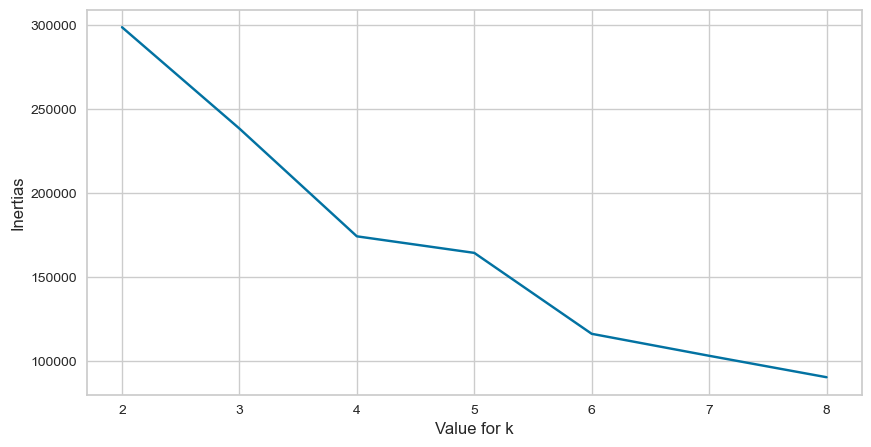

In [26]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Connexion à la base de données SQLite
conn = sqlite3.connect("olist.db")

# Exécution de la requête SQL pour extraire les données
sql_query = pd.read_sql_query(
    """WITH location AS
    (SELECT geolocation_zip_code_prefix, AVG(geolocation_lat) AS latt, AVG(geolocation_lng) AS long
    FROM geoloc
    GROUP BY geolocation_zip_code_prefix),
    pricing AS 
    (SELECT order_id, SUM(price) AS sales, AVG(freight_value/(price+freight_value)) AS shipping,
    SUM(price+freight_value) AS total
    FROM (SELECT DISTINCT order_items.order_id, order_items.seller_id, order_items.price, order_items.freight_value
    FROM order_items) 
    GROUP BY order_id)
    SELECT customer_unique_id, count(*) AS total_purchase, latt, long, customer_state,
    (julianday(date('2018-10-17')) - julianday(MIN(order_purchase_timestamp)))/30.42 AS seniority,
    MAX(order_purchase_timestamp) AS latest_purchase, 
    AVG(julianday(order_estimated_delivery_date) - julianday(order_purchase_timestamp)) AS delivery_time,
    AVG(julianday(order_delivered_customer_date) - julianday(order_estimated_delivery_date)) AS delay,
    sales, shipping, total, AVG(review_score) AS average_score
    FROM customers
    LEFT JOIN location ON customers.customer_zip_code_prefix = location.geolocation_zip_code_prefix
    LEFT JOIN orders ON customers.customer_id = orders.customer_id
    LEFT JOIN pricing ON orders.order_id = pricing.order_id
    LEFT JOIN order_reviews ON orders.order_id = order_reviews.order_id
    WHERE orders.order_status = 'delivered'
    GROUP BY customer_unique_id
    ORDER BY total_purchase DESC;""",
    conn)

# Création d'un DataFrame à partir des résultats de la requête
olist = pd.DataFrame(sql_query)

# Définir 'customer_unique_id' comme index du DataFrame
olist = olist.set_index('customer_unique_id')

# Conversion des dates au format datetime
olist['latest_purchase'] = pd.to_datetime(olist['latest_purchase'], format="%Y-%m-%d %H:%M:%S")

# Remplacer les valeurs manquantes
olist.loc[olist['delay'].isna(), 'delay'] = 0
olist.loc[olist['average_score'].isna(), 'average_score'] = 2.5

# Remplacer les valeurs manquantes pour 'latt' et 'long'
customer_state = list(olist['customer_state'].value_counts().index)
for state in customer_state:
    olist.loc[(olist['customer_state'] == state) & (olist['latt'].isna()), 'latt'] = \
        state_data['latt'].median()
    olist.loc[(olist['customer_state'] == state) & (olist['long'].isna()), 'long'] = \
        state_data['long'].median()
    
# Liste des colonnes quantitatives
elements = [col for col in olist.columns if olist[col].dtype != object]

# Suppression des colonnes non nécessaires
olist.drop(columns=['sales'], inplace=True)
olist.drop(columns=['seniority'], inplace=True)
elements.remove('sales')
elements.remove('seniority')

# Création d'une colonne pour la durée depuis la dernière achat
olist['latest_purchase'] = pd.to_datetime(olist['latest_purchase'])
reference_date = pd.Timestamp("2018-10-17")
olist['latest_purchase_numeric'] = (reference_date - olist['latest_purchase']) // pd.Timedelta('1D')
elements.remove('latest_purchase')
elements.append('latest_purchase_numeric')


outliers = {}
for i in elements:
    outliers[i] = pd.DataFrame()
    for j in olist['customer_state'].unique():
        group_data = olist[olist['customer_state'] == j]
        Q1 = group_data[i].quantile(0.05)
        Q3 = group_data[i].quantile(0.95)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_for_column = group_data[(group_data[i] < lower_bound) | (group_data[i] > upper_bound)]
        outliers[i] = pd.concat([outliers[i], outliers_for_column])

# Correction des valeurs aberrantes
latt = outliers['latt'].index
long = outliers['long'].index

for state in olist['customer_state'].unique():
    olist.loc[
        (olist.index.isin(latt_outliers)) & (olist['customer_state'] == state),
        'latt'] = olist.loc[olist['customer_state'] == state, 'latt'].median()
    olist.loc[
        (olist.index.isin(long_outliers)) & (olist['customer_state'] == state),
        'long'] = olist.loc[olist['customer_state'] == state, 'long'].median()
    
# Suppression de la colonne 'customer_state'
olist.drop(columns=['customer_state'], inplace=True)

# Sélection des colonnes pour le clustering
rfm = ['total_purchase', 'total', 'latest_purchase_numeric', 'average_score']
rfm = olist[rfm]

# Normalisation des données
standardscaler = StandardScaler().fit(rfm)
X = pd.DataFrame(
    standardscaler.transform(rfm),
    columns=rfm.columns,
    index=rfm.index)

# Calcul des inertias pour différents nombres de clusters
k = [2, 3, 4, 5, 6, 7, 8]
inertias = []
for i in k:
    km = KMeans(n_clusters=i, n_init='auto', random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

# Affichage du graphique de l'inertie
plt.figure(figsize=(10, 5))
plt.plot(k, inertias, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.title("Évaluation du nombre optimal de clusters")
plt.grid()
plt.show()

Phénomène rare mais loin d'être impossible, le graphique ci-dessus démontre la présence de 2 coudes. Cela indique que les valeurs 4 et 6 de k constituent des candidats potentiels pour le choix du nombre optimal de clusters. Tout va se jouer en fonction du calcul du silhouette score qui va suivre.

## 2. Silhouette Score<a name=4 ></a>

Le score de silhouette mesure la cohésion interne des clusters (la distance moyenne entre les points dans le même cluster) et la séparation entre les clusters (la distance moyenne entre un point et les points des autres clusters). Un score de silhouette plus élevé indique des clusters bien définis:

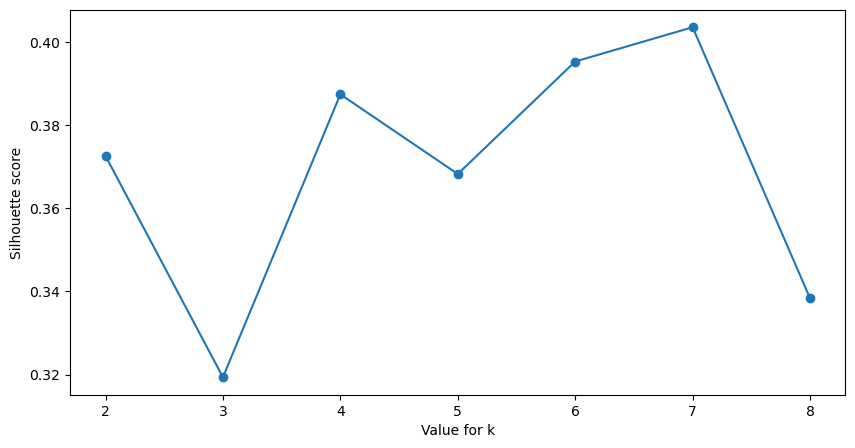

In [2]:
from sklearn.metrics import silhouette_score

# Liste pour stocker les scores de silhouette pour chaque nombre de clusters
scores = []

# Calcul des scores de silhouette pour différents nombres de clusters
for n_clusters in k:
    kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42).fit(X)
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    scores.append(silhouette_avg)

# Création du graphique des scores de silhouette
plt.figure(figsize=(10, 5))
plt.plot(k, scores, 'o-')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score de Silhouette")
plt.title("Évaluation de la qualité du clustering")
plt.grid()
plt.show()

Le score de silhouette est plus élevé pour k=6, ce qui suggère que 6 clusters pourraient mieux représenter la structure des données. Pour valider ce choix, nous visualisons les silhouettes pour k=4, k=5, et k=6 en utilisant l'outil SilhouetteVisualizer:

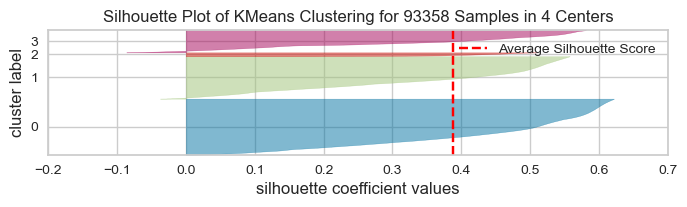

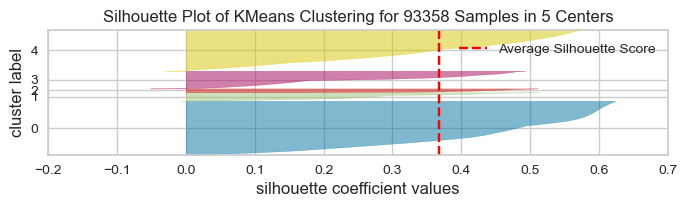

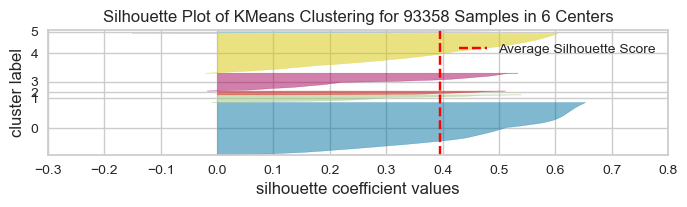

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [3]:
from yellowbrick.cluster import SilhouetteVisualizer

# Visualisation pour k = 4
plt.subplot(3, 1, 1)
model = KMeans(n_clusters=4, n_init="auto", random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()

# Visualisation pour k = 5
plt.subplot(3, 1, 2)
model = KMeans(n_clusters=5, n_init="auto", random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()

# Visualisation pour k = 6
plt.subplot(3, 1, 3)
model = KMeans(n_clusters=6, n_init="auto", random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()

Avec un score très proche de 0.4, les silhouettes pour k=6 affichent bien le score le plus élevé, ce qui confirme la pertinence du choix de 6 clusters pour notre modèle K-means. La dernière étape pour confirmer ce choix est d'étudier la stabilité du modèle K-means, ce que nous ferons dans la partie suivante en effectuant une série de calculs autour de l'indice de Rand.

## 3. Stabilité des Clusters<a name=5 ></a>

L'indice de Rand (ou Adjusted Rand Score en anglais) est une mesure de similarité entre deux partitions d'un ensemble. Il est principalement utilisé en catégorisation automatique. Son principe est de mesurer la consistance (le taux d'accord) entre deux partitions. 

Dans notre contexte, il est important de noter que l'un des inconvénients majeurs de la méthode de clustering des k-means se trouve dans l'aspect aléatoire du procéssus de clustering selon le volume et l'homogénéité du dataset traité. En effet, pour un même dataset donné, l'attribution finale des groupes pour chaque individu peut différer significativement en termes de caractéristiques. Pour autant, cet aspect aléatoire peut être paramétré à l'avance.

De plus, le recours ici à l'indice de Rand va nous permettre de mesurer concrètement l'impact de cette problématique. Ici, nous allons évaluer la stabilité des clusters, dans un premier temps, par bootstrap, qui consiste à répéter plusieurs fois le processus de clustering sur des échantillons de la base de données.

De cette série de clusterings, nous calculerons pour chacun d'entre le niveau de similitude dans les distributions via donc l'Adjusted Rand Score. Ainsi, une moyenne et une médiane élevée de cette série de scores signifiera que l'algorithme de clustering via la méthode k-means, pour un nombre de clusters donné et appliqué à notre dataset ici présent, est suffisamment stable pour être validé:

In [27]:
from sklearn.metrics import adjusted_rand_score
import statistics

# Initialisation des modèles KMeans
kmeans4 = KMeans(n_clusters=4, n_init='auto')
kmeans4.fit(X)
clusters4 = kmeans4.labels_
kmeans5 = KMeans(n_clusters=5, n_init='auto')
kmeans5.fit(X)
clusters5 = kmeans5.labels_
kmeans6 = KMeans(n_clusters=6, n_init='auto')
kmeans6.fit(X)
clusters6 = kmeans6.labels_

# Listes pour stocker les scores ARI
results4 = []
results5 = []
results6 = []

# Calcul des scores ARI pour chaque nombre de clusters
for i in range(20):
    kmeans_new4 = KMeans(n_clusters=4, n_init='auto')
    kmeans_new4.fit(X)
    clusters_new4 = kmeans_new4.labels_
    ari_score4 = adjusted_rand_score(clusters4, clusters_new4)
    results4.append(ari_score4)
    kmeans_new5 = KMeans(n_clusters=5, n_init='auto')
    kmeans_new5.fit(X)
    clusters_new5 = kmeans_new5.labels_
    ari_score5 = adjusted_rand_score(clusters5, clusters_new5)
    results5.append(ari_score5)
    kmeans_new6 = KMeans(n_clusters=6, n_init='auto')
    kmeans_new6.fit(X)
    clusters_new6 = kmeans_new6.labels_
    ari_score6 = adjusted_rand_score(clusters6, clusters_new6)
    results6.append(ari_score6)

# Calcul et affichage des statistiques des scores ARI
print("ARI Score Mediane (4 clusters) =",statistics.median(results4),"Moyenne =",sum(results4)/len(results4))
print("ARI Score Mediane (5 clusters) =",statistics.median(results5),"Moyenne =",sum(results5)/len(results5))
print("ARI Score Mediane (6 clusters) =",statistics.median(results6),"Moyenne =",sum(results6)/len(results6))

ARI Score Mediane (4 clusters) = 0.8979208742654079 Moyenne = 0.8013913057664721
ARI Score Mediane (5 clusters) = 0.9996576410301276 Moyenne = 0.964308486924673
ARI Score Mediane (6 clusters) = 0.9104367183840976 Moyenne = 0.8206177940897158


Quel que soit le nombre de clusters choisi, ces derniers sont significativement stables, comme le montrent les moyennes et médianes calculées ci-dessus sur un ensemble de 20 modèles. Concernant le choix de la valeur 6, la stabilité du modèle est ici moins importante que pour les valeurs 4 et 5. Pour autant, elle est suffisamment élevée pour considérer que notre algorithme est fiable.

Ainsi donc, l'ensemble des méthodes appliquées dans cette partie nous permet de déterminer que 6 constitue le nombre optimal de clusters à appliquer pour notre dataset, et par conséquent de porter notre choix final sur cette valeur.

Nous allons donc maintenant nous focaliser sur la dernière partie de ce modèle de segmentation qui consiste à analyser les caractéristiques propres à chacun de notre 6 clusters nouvellement créées à partir du modèle k-means.

## 4. Caractéristiques des Clusters<a name=6 ></a>

Pour ce dernière chapitre, nous observerons les valeurs de l'ensemble des features et ainsi élaborer une première segmentation hypothétique de la clientèle d'Olist. La comparaison des différentes segmentations en fonction des modèles de clustering appliqué permettra, in fine, de déterminer l'algorithme le plus pertinent pour répondre à la problématique d'Olist.

Pour cela, nous allons visualiser, en premier lieu, la répartition de l'ensemble des clients entre chacun de nos 6 clusters. En effet, si un ou plusieurs clusters regroupent un nombre trop important ou bien trop faible d'individus, nous pouvons considérer que le modèle n'est pas assez homogène, ce qui peut avoir une incidence sur la pertinence des résultats. Dans notre cas de figure, nous savons d'avance qu'il existe un nombre extrêmement minoritaire de clients avec des comportements d'achat très spécifique. Cependant, au vu du volume de notre dataset, nous devrions retrouver des chiffres suffisamment élevés pour l'ensemble des clusters, et ce malgré une répartition inégale.

In [28]:
# Initialisation du modèle KMeans avec 6 clusters
kmeans = KMeans(n_clusters=6, n_init="auto", random_state=42)

# Ajustement du modèle et prédiction des clusters
kmeans.fit(X)
clusters = kmeans.labels_

# Création d'un DataFrame pour stocker les résultats des clusters
kmeans = pd.DataFrame({"customer_unique_id":X.index,"customer_id":X.index,"Cluster kmeans": clusters})

# Définition de 'customer_unique_id' comme index du DataFrame
kmeans = kmeans.set_index('customer_unique_id')

# Conversion des labels de cluster en chaînes de caractères
kmeans['Cluster kmeans'] = kmeans['Cluster kmeans'].astype(str)

# Comptage du nombre de clients par cluster
kmeans.groupby(['Cluster kmeans']).count()

,customer_id
Cluster kmeans,
0,39482
1,5759
2,2874
3,13400
4,29684
5,2159


Nous pouvons considérer ici que la répartition des clients sur nos 6 groupes est acceptable, dans la mesure où même le plus petit des groupes (5) rassemble plus de 2000 individus.

En partant de ce constat, nous allons visualiser, en premier lieu, la moyenne brute des variables de chaque cluster. Nous développerons, par la suite, une heatmap basée sur les valeurs standardisées de notre dataset et nous permettant d'interpréter de manière plus visible les tendances et les contrastes présents entre nos clusters:

In [29]:
# Concatenation des DataFrames olist et kmeans sur l'axe des colonnes
standard = pd.concat([olist, kmeans], axis=1)

# Suppression de la colonne 'customer_id'
standard.drop(columns=['customer_id'], inplace=True)

# Calcul et affichage de la moyenne des variables par cluster
standard.groupby(['Cluster kmeans']).mean()

,total_purchase,latt,long,latest_purchase,delivery_time,delay,shipping,total,average_score,latest_purchase_numeric
Cluster kmeans,,,,,,,,,,
0,1.000000,-21.423233,-46.326386,2018-04-27 23:39:06.783952128,22.651656,-12.088267,0.211213,125.013590,4.753609,171.651487
1,1.000000,-20.719806,-45.860121,2017-07-02 01:35:22.152977920,25.273240,-9.591347,0.219740,126.453487,2.106963,471.577357
2,2.263744,-21.561760,-46.313747,2018-01-19 17:37:31.993041152,24.210855,-11.862512,0.215922,124.714398,4.190331,269.888657
3,1.000000,-20.864588,-45.826001,2018-03-19 15:53:45.298880768,24.057969,-5.203127,0.217863,134.910261,1.878172,210.970000
4,1.000000,-21.168370,-46.241728,2017-08-06 22:37:52.487569152,24.475843,-12.769512,0.209148,124.263077,4.740331,435.695964
5,1.007874,-19.594266,-45.877966,2018-01-01 02:44:48.895785216,25.881254,-11.811538,0.055175,1120.154405,4.188282,288.523854


<Axes: ylabel='Cluster kmeans'>

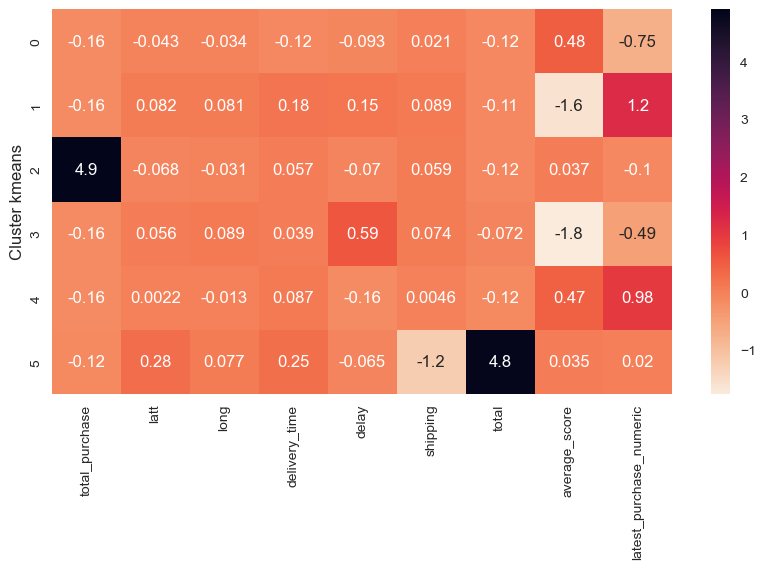

In [30]:
import seaborn as sns

# Normalisation des données avec StandardScaler
standardscaler = StandardScaler().fit(standard[elements])

# Création d'un DataFrame avec les données normalisées
X = pd.DataFrame(standardscaler.transform(standard[elements]), columns=standard[elements].columns, index=standard[elements].index)

# Concatenation des données normalisées avec les clusters
X = pd.concat([X, kmeans], axis=1)

# Suppression de la colonne 'customer_id'
X.drop(columns=['customer_id'], inplace=True)

# Création de la heatmap des moyennes par cluster
plt.figure(figsize=(10, 5))
cmap = sns.cm.rocket_r
sns.heatmap(X.groupby(['Cluster kmeans']).mean(), annot=True, cmap = cmap)

A partir des analyses ci-dessus, nous pouvons d'ores et déjà effectuer une première segmentation de notre clientèle. En effet, nous pouvons observer des caractéristiques et des tendances comportementales d'achat spécifiques pour chacun des 6 groupes. Ainsi, il est déjà possible pour l'entreprise Olist, de se baser sur la segmentation qui vient d'être opérée ici pour cibler les clients de manière plus juste avec des stratégies marketing personnalisées, ou bien encore pour optimiser les opérations en fonction des besoins de chaque segment.

Cependant, il s'agit du premier algorithme que nous testons. Afin de s'assurer du choix de segmentation que l'on souhaite faire, il est nécessaire d'essayer d'autres modèles de clustering et de comparer les résultats entre eux. Les différentes étapes des procéssus de modélisation peuvent également jouer un rôle clé dans notre choix final.

Voilà pourquoi nous allons désormais nous pencher, comme mentionné dans l'introduction de cette étude, sur un deuxième modèle de clusterisation que l'on nomme "Agglomerative Clustering".

# II. Segmentation par Agglomerative Clustering<a name=7 ></a>

Le clustering hiérarchique (ou agglomerative clustering en anglais) est une méthode de regroupement qui commence par traiter chaque point de données comme un cluster individuel. Ensuite, il fusionne les clusters par paires en fonction d'un critère de distance, jusqu'à ce qu'il ne reste plus qu'un seul cluster ou jusqu'à un nombre de clusters prédéfini. Dans ce cadre, le critère de linkage='ward' est couramment utilisé car il minimise la variance totale au sein des clusters.

Comme dans le modèle précédent, le choix du nombre de clusters est crucial. C'est pourquoi nous allons tracer l'inertie, dans ce cadre la cutoff distance, en fonction du nombre de clusters pour aider à déterminer le nombre optimal de clusters à adopter. 

## 1. Calcul de l'Inertie<a name=8 ></a>

La cutoff distance (ou threshold distance) est une valeur seuil utilisée dans le clustering hiérarchique, en particulier lors de la construction d'un dendrogramme. Elle représente la distance au-delà de laquelle les clusters ne sont plus fusionnés. En d'autres termes, elle définit un niveau de dissimilarité à partir duquel on arrête le processus de fusion des clusters, permettant ainsi de déterminer le nombre final de clusters. Cette distance de seuil est choisie pour "couper" le dendrogramme à une certaine hauteur, ce qui divise les données en plusieurs groupes distincts. Le choix de cette distance influe directement sur le nombre et la composition des clusters obtenus.

Nous allons ainsi créer un graphique en escalier montrant l'évolution de l'inertie en fonction du nombre de clusters. Ce graphique nous aidera à décider du nombre optimal de clusters en recherchant un "coude" dans la courbe, où l'augmentation de l'inertie ralentit après une certaine valeur, ce qui signifie qu'ajouter des clusters supplémentaires ne réduit pas beaucoup l'inertie (variance intra-cluster).

A noter, cependant, que pour cet exercice, nous avons sélectionné un échantillon aléatoire de 10000 clients de notre dataset. En effet, l'inconvénient majeur du modèle ici repose en grande partie sur le fait que cette méthode de clustering ne peut s'appliquer que sur des dataset contenant un nombre limité d'individus et de features:

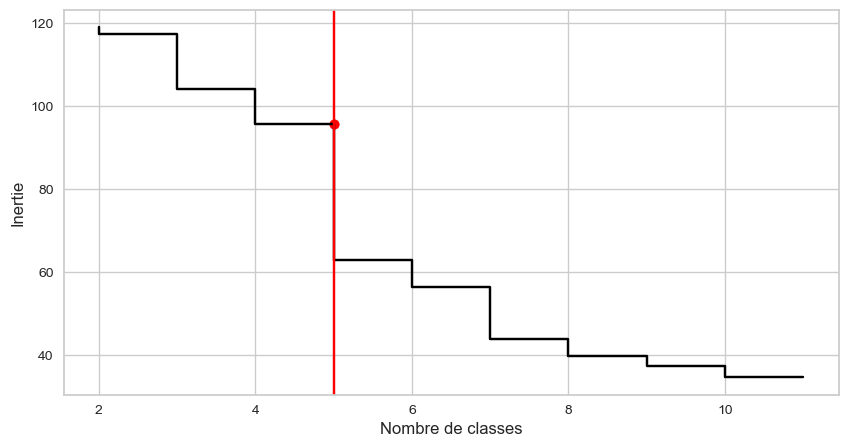

In [31]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster

# Échantillonnage de 10 000 observations de X
sampled_X = X.sample(n=10000, random_state=42)

# Colonnes à utiliser pour le clustering
rfm = ['total_purchase', 'total', 'latest_purchase_numeric','average_score']

# Calcul des liens hiérarchiques
Z = linkage(sampled_X[rfm].values, 'ward')

# Récupération des dernières inerties pour déterminer le nombre optimal de clusters
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(2, len(last) + 2)

# Visualisation du coude de l'inertie
plt.figure(figsize=(10, 5))
plt.step(idxs, last_rev, c="black")
plt.xlabel("Nombre de classes")
plt.ylabel("Inertie")

# Indication du nombre choisi de clusters
nombre = 5
plt.scatter(idxs[np.where(idxs==nombre)], last_rev[np.where(idxs==nombre)], c="red")
plt.axvline(idxs[np.where(idxs==nombre)], c="red")
plt.show()

D'après le graphique ci-dessus, aucun doute ne nous es permis: le nombre optimal de clusters pour ce modèle est de 5. Nous allons donc sans plus tarder appliquer notre modèle de clustering hiérarchique sur notre échantillon d'individus et analyser les résultats de ce clustering.

## 2. Caractéristiques des Clusters<a name=9 ></a>

In [32]:
# Attribution des clusters hiérarchiques avec 5 clusters
clusters = fcluster(Z, 5, criterion='maxclust')

# Création d'un DataFrame avec les clusters obtenus
cah = pd.DataFrame({
    "customer_unique_id": sampled_X.index,
    "customer_id": sampled_X.index,
    "Cluster CAH": clusters})

# Réglage de l'index et conversion de la colonne des clusters en chaîne de caractères
cah = cah.set_index('customer_unique_id')
cah['Cluster CAH'] = cah['Cluster CAH'].astype(str)

# Affichage du nombre d'observations dans chaque cluster
cah.groupby(['Cluster CAH']).count()

,customer_id
Cluster CAH,
1,1707
2,313
3,2099
4,5289
5,592


Dans ce cas de figure, à l'instar du modèle précédent, la répartition numérique de nos 5 clusters semble suffisamment homogène tout en prenant bien en compte l'existence de certains outliers parmi la clientèle. Penchons-nous maintenant sur la moyenne brute des variables par cluster ainsi que sur la heatmap construite de la même manière que précédemment:

In [33]:
# Copie de l'échantillon de données
std_sampled_X = sampled_X.copy()

# Fusion de l'échantillon avec le DataFrame principal en utilisant 'customer_unique_id'
sampled_X = pd.merge(sampled_X, olist, on='customer_unique_id', how='left')

# Mise à jour des colonnes dans 'sampled_X' en fonction des suffixes
for column in elements:
    sampled_X[column] = sampled_X[f'{column}_y']

# Sélection des colonnes pertinentes pour le DataFrame final
sampled_X = sampled_X[elements]

# Création du DataFrame 'standard' en concaténant les données d'échantillon avec les clusters
standard = pd.concat([sampled_X, cah], axis=1)

# Suppression de la colonne 'customer_id'
standard.drop(columns=['customer_id'], inplace=True)

# Calcul et affichage de la moyenne des variables pour chaque cluster
standard.groupby('Cluster CAH').mean()

,total_purchase,latt,long,delivery_time,delay,shipping,total,average_score,latest_purchase_numeric
Cluster CAH,,,,,,,,,
1,1.000000,-20.881317,-45.788741,24.149385,-5.745971,0.224134,116.897428,1.788518,256.881078
2,2.188498,-21.586974,-46.782955,23.636904,-11.287429,0.213281,128.544760,4.137114,272.923323
3,1.000000,-21.184919,-46.228925,25.262786,-13.645206,0.219322,107.706241,4.527156,497.557885
4,1.000000,-21.295338,-46.313259,22.993253,-11.891942,0.214217,114.492602,4.716203,214.600870
5,1.000000,-20.353909,-46.003440,24.245227,-11.656451,0.075336,699.992027,4.409628,234.670608


<Axes: ylabel='Cluster CAH'>

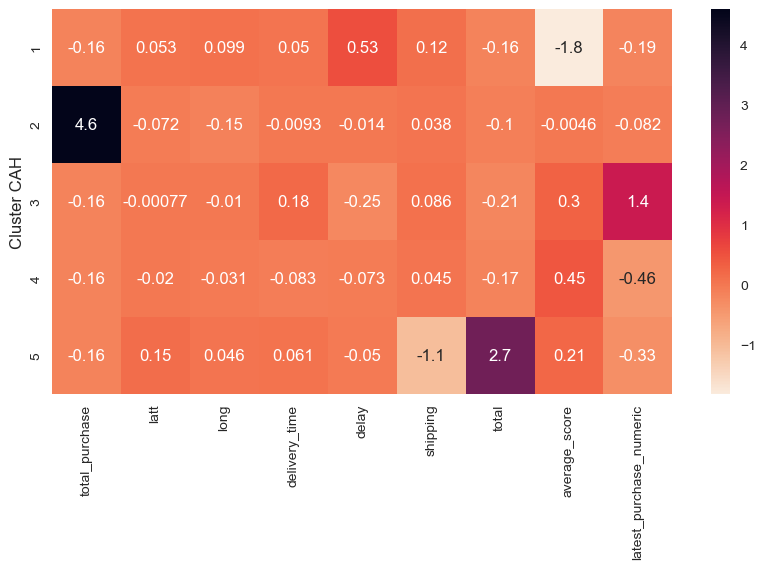

In [34]:
# Création du DataFrame 'standard' en concaténant les données d'échantillon avec les clusters
standard = pd.concat([std_sampled_X, cah], axis=1)

# Suppression de la colonne 'customer_id'
standard.drop(columns=['customer_id'], inplace=True)

# Configuration de la taille de la figure pour l'affichage de la heatmap
plt.figure(figsize=(10, 5))

# Affichage de la heatmap des moyennes par cluster
sns.heatmap(
    standard.drop(columns=['Cluster kmeans'])
    .groupby(['Cluster CAH'])
    .mean(),
    annot=True,
    cmap=cmap)

L'agglomerative clustering, avec le critère de liaison Ward, a permis de segmenter les clients d'Olist en 5 clusters hiérarchisés, offrant une vision de la structure sous-jacente des données. Cette approche est particulièrement utile pour les données où une hiérarchie naturelle entre les groupes de clients peut être déduite.

Cependant, nous pouvons observer de très grandes similitudes avec le clustering fait par la méthode k-means. Là aussi, chaque cluster du modèle hiérarchique peut être mis en parallèle avec l'un de ceux développés par le modèle précédent, à une exception près qui est que le modèle k-means présente un cluster supplémentaire dans sa segmentation, dans lequel la variable "latest_purchase_numeric" est particulièrement élevé, autant que la variable "average_score" est faible.

Nous pouvons considérer que ce profil de client peut être tout aussi intéressant à étudier et c'est pourquoi le choix de 6 clusters via le modèle k-means demeure une meilleure option. De plus, et quoi qu'il en soit, le choix de l'agglomerative clustering ne sera pas ici retenu, dans la mesure où notre dataset est considéré comme trop volumineux pour son application.

Maintenant que nous avons pu comparer 2 modèles de clusterisation, il est temps d'essayer notre troisième et dernier modèle : DHSCAN.

# III. Segmentation par DBSCAN<a name=10 ></a>

Le modèle DBSCAN (Density-Based Spatial Clustering of Applications with Noise) est une technique de clustering basée sur la densité. Contrairement à K-Means et Agglomerative Clustering, DBSCAN ne nécessite pas de spécifier un nombre de clusters au préalable. En effet, il est ici possible de détecter des clusters de formes arbitraires et d'identifier les points aberrants (outliers).

Toutefois, la performance et la fiabilité des résultats de DBSCAN dépendent grandement des paramétrages établis au préalable. Il est ainsi important, avant d'appliquer le modèle, de définir les paramétrages suivants:
- eps: La distance maximale entre deux échantillons pour qu'ils soient considérés comme faisant partie du même voisinage.
- min_samples: Le nombre minimum de points requis pour former un cluster.

Nous allons ainsi, dans cette partie de l'étude, avoir recours à une approche empirique pour repérer et retenir les paramètres optimaux de notre modèle à utiliser sur notre dataset. Ici, le paramétrage final retenu sera celui qui aboutira à un nombre de clusters le moins élevé possible:

In [12]:
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import DBSCAN

# Définition de la grille de paramètres pour DBSCAN
eps_range = np.arange(0.5, 1, 0.1)
min_samples_range = np.arange(5, 10, 1)

param_grid = {'eps': eps_range, 'min_samples': min_samples_range}

best_params = None
best_score = 93358
results = []

def evaluate_dbscan(eps, min_samples):
    """
    Évalue le modèle DBSCAN avec les paramètres donnés.

    Args:
        eps (float): La distance maximale entre deux points pour les considérer comme voisins.
        min_samples (int): Le nombre minimum de points pour former un noyau dense.

    Returns:
        tuple: Le nombre de clusters, le nombre de points considérés comme du bruit (outliers),
               et le modèle DBSCAN entraîné.
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X[rfm])
    cluster_labels = dbscan.labels_
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    return n_clusters, n_noise, dbscan

for params in ParameterGrid(param_grid):
    eps = params['eps']
    min_samples = params['min_samples']
    try:
        n_clusters, n_noise, model = evaluate_dbscan(eps, min_samples)
        results.append((eps, min_samples, n_clusters, n_noise))
        if n_clusters <= best_score:
            outliers = n_noise
            best_score = n_clusters
            best_params = params
    except Exception as e:
        print(f"DBSCAN failed for eps={eps}, min_samples={min_samples}: {e}")
        
print(f"Best parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
print(f'Number of clusters found: {best_score}')
print(f"Best score (number of outliers (noise)): {outliers}")

Best parameters: eps=0.8999999999999999, min_samples=9
Number of clusters found: 6
Best score (number of outliers (noise)): 154


D'après notre série de calculs, le meilleur paramétrage de DBSCAN serait constitue d'un eps égal à 0.9 et d'un min_samples égal à 9. Cela permet au modèle de développer un ensemble de 6 clusters, malgré le fait que 154 clients n'ont pas été pris en compte car considérés comme des outliers.

Si ces chiffres semblent bons, nous nous devons d'analyser les résultats et vérifier l'efficacité de DBSCAN :

In [14]:
# Application de DBSCAN avec des paramètres spécifiques
dbscan = DBSCAN(eps=0.9, min_samples=8)
dbscan.fit(X[rfm])
cluster_labels = dbscan.labels_

# Création d'un DataFrame pour les clusters DBSCAN
db = pd.DataFrame({
    "customer_unique_id": X.index,
    "customer_id": X.index,
    "Cluster DB": cluster_labels})

# Configuration de l'index et conversion du type de colonne
db = db.set_index('customer_unique_id')
db['Cluster DB'] = db['Cluster DB'].astype(str)

# Affichage du nombre d'éléments dans chaque cluster
db.groupby(['Cluster DB']).count()

,customer_id
Cluster DB,
-1,151
0,12
1,105
2,356
3,2342
4,90374
5,18


<Axes: ylabel='Cluster DB'>

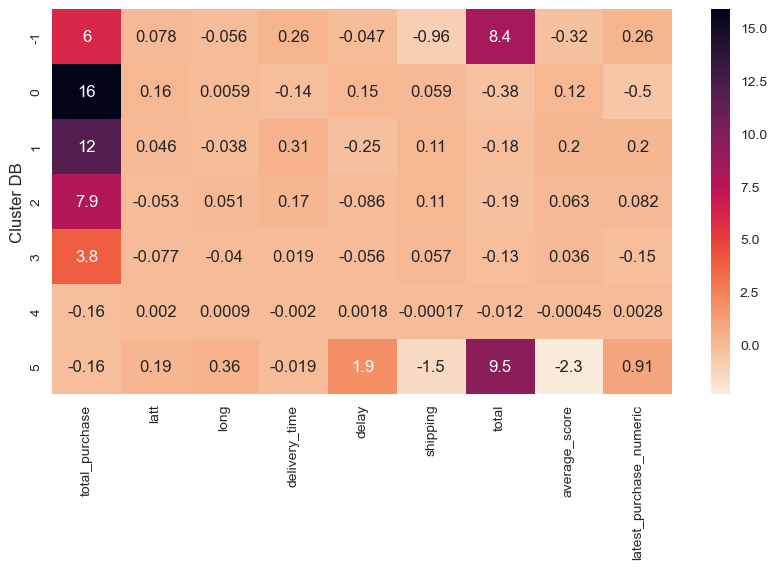

In [15]:
# Concaténation des DataFrames X et db
standard = pd.concat([X, db], axis=1)

# Suppression de la colonne 'customer_id'
standard.drop(columns=['customer_id'], inplace=True)

# Création de la figure pour la heatmap
plt.figure(figsize=(10, 5))

# Création et affichage de la heatmap
sns.heatmap(
    standard.drop(columns=['Cluster kmeans'])
    .groupby(['Cluster DB'])
    .mean(),
    annot=True,
    cmap=cmap)

DBSCAN a permis d'identifier des clusters de formes irrégulières et de détecter des outliers parmi les clients. Cette méthode s'est avérée particulièrement utile pour les données contenant des anomalies ou des distributions complexes, offrant ainsi une perspective complémentaire à celle de K-Means.

Cependant, dans notre cas de figure, l'utilité du modèle DBSCAN s'arrête là. En effet, la répartition numérique entre clusters, contrairement aux 2 modèles précédents, est tout simplement catastrophique. Entre le groupe 0 regroupant 12 individus et le groupe 4 en regroupant plus de 90.000, il est inutile de chercher plus loin : DBSCAN est catégoriquement exclu de notre étude!

De plus, même si l'on ne peut que difficilement l'imaginer par la simple lecture de ce rapport, le processus de recherche des paramétrages optimaux et l'application de ces derniers a été excessivement long à exécuter et tout aussi excessivement gourmant en termes de mémoire.

Quoi qu'il en soit, comparer les résultats des différentes méthodes de segmentation permet de comprendre leurs avantages et inconvénients respectifs, et de choisir la méthode la plus adaptée aux objectifs de l'entreprise. Dans cette section, nous avons donc eu l'occasion de comparer K-Means, Agglomerative Clustering et DBSCAN sur la base de leurs clusters, robustesse aux outliers, simplicités d'utilisation et d'interprétation.

Ici, en raison des inconvénients majeurs des 2 autres modèles, mais également au vu des résultats plus que satisfaisants observés, notre choix final s'est porté sur le modèle K-Means. Ainsi, à partir des clusters réalisées par ce dernier, nous sommes en mesure d'effectuer une analyse approfondie des groupes de clients résultant de notre opération de segmentation. De par la série d'analyses qui va suivre, nous pourrons dès lors répondre concrêtement et définitivement aux problématiques d'Olist et de parachever notre mission auprès de cette entreprise.

# IV. Analyse des Segments<a name=11 ></a>

Dans cette section, nous allons donc explorer en profondeur les résultats du modèle KMeans, en analysant la distribution des différents clusters, leur contribution au chiffre d'affaires global et leur répartition géographique. Ces visualisations permettront d'identifier les particularités de chaque groupe de consommateurs et d'établir des stratégies ciblées en fonction des comportements observés. Après avoir déterminé le nombre optimal de clusters dans la partie précédente, nous nous concentrerons ici sur la répartition des consommateurs selon leurs caractéristiques, ainsi que leur impact financier et leur localisation géographique.

## 1. Distribution des Variables par Cluster KMeans<a name=12 ></a>

Afin de mieux comprendre les caractéristiques spécifiques de chaque groupe de consommateurs, nous utilisons des boîtes à moustaches (boxplots) pour visualiser la distribution des variables pertinentes telles que le montant total des achats (total_purchase), le total global des transactions (total), la date du dernier achat (latest_purchase_numeric), et la note moyenne (average_score). Ces représentations graphiques permettent de comparer les variations entre les clusters identifiés par KMeans, offrant ainsi un aperçu clair des distinctions majeures entre les groupes de clients:

<Figure size 1500x750 with 0 Axes>

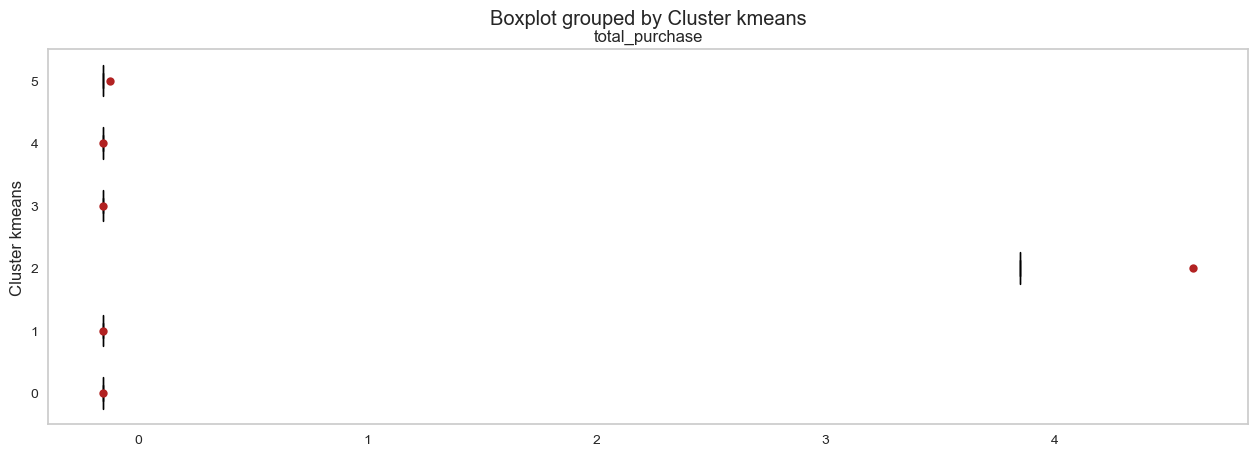

<Figure size 1500x750 with 0 Axes>

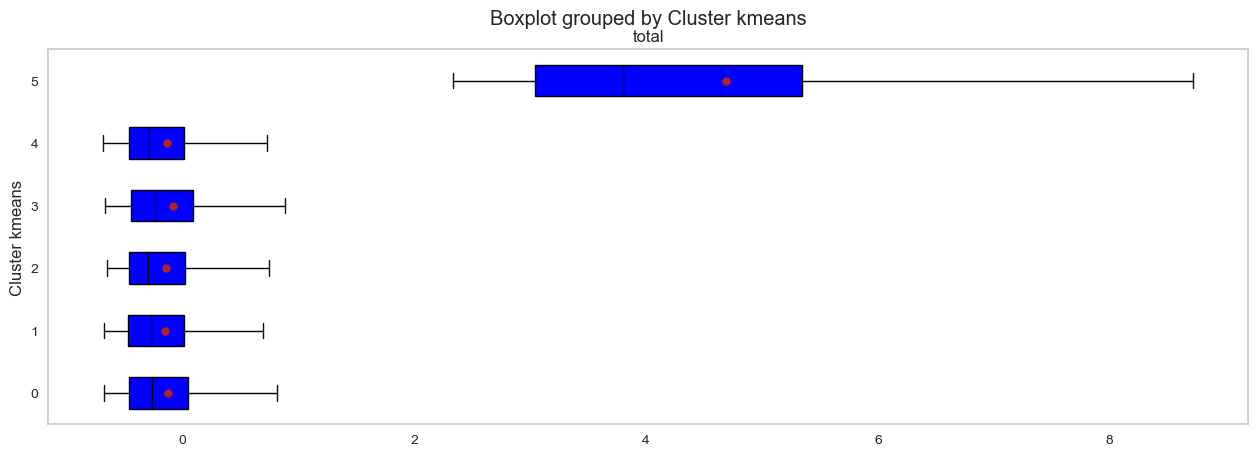

<Figure size 1500x750 with 0 Axes>

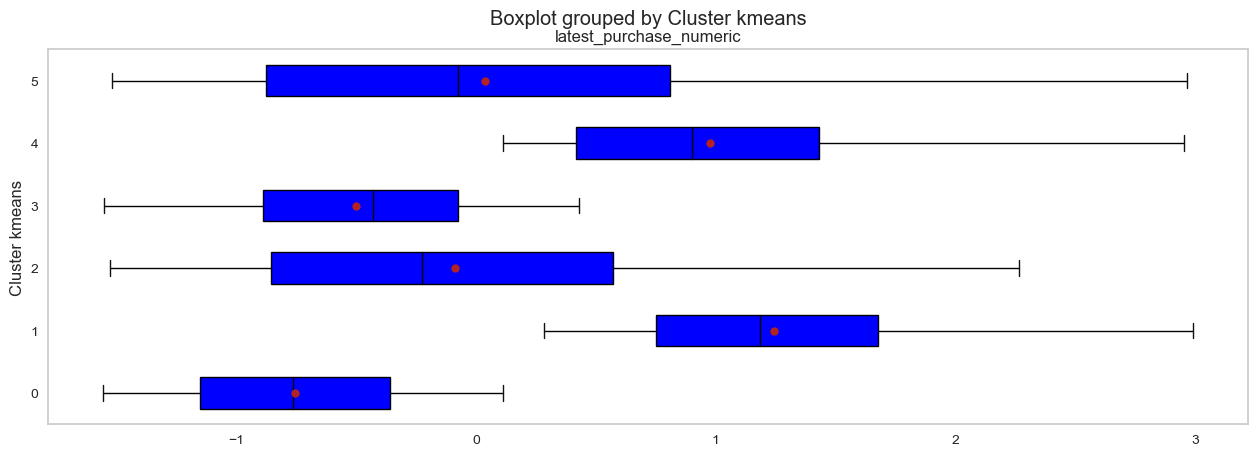

<Figure size 1500x750 with 0 Axes>

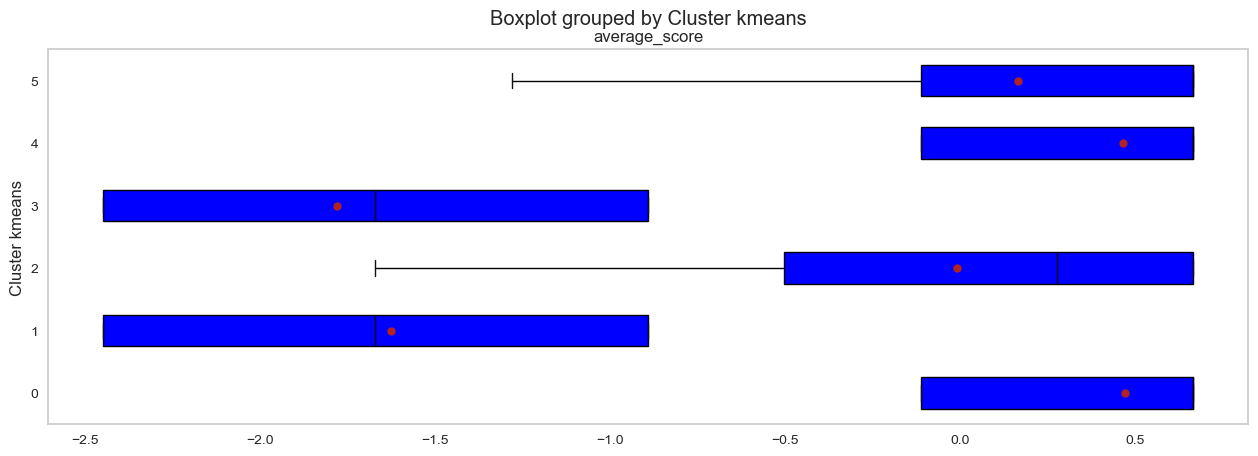

In [35]:
# Définition des propriétés pour les éléments de la boîte à moustaches
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}

# Création des boxplots pour chaque colonne spécifiée
for column in ['total_purchase', 'total', 'latest_purchase_numeric', 'average_score']:
    plt.figure(figsize=(15, 7.5))
    
    # Création du boxplot
    standard.boxplot(
        column=column,
        by='Cluster kmeans',
        figsize=[15, 5],
        medianprops=medianprops,
        showmeans=True,
        meanprops=meanprops,
        vert=False,
        showfliers=False,
        patch_artist=True,
        boxprops=dict(facecolor="blue", color="black"))
    
    # Ajout de la grille et affichage du plot
    plt.grid()
    plt.show()

A partir de l'ensemble des comportements observés à travers cette série de diagrammes à moustaches, ainsi que de la heatmap établie dans la partie précédente, nous connaissons désormais les caractéristiques de chacun des 6 groupes de clientèle. Cette dernière se divise donc en 6 catégories de consommateurs que nous allons décrire comme suit :
0. Les newcomers : cette catégorie de consommateurs regroupe les clients dont la dernière opération d'achat a été effectuée très récemment. Ils ont ainsi découvert Olist il y a peu et représentent un enjeu majeur pour la suite des activités de l'entreprise. La grande majorité d'entre eux n'ont effectué qu'un seul achat, mais il en existe quelques uns qui ont dépassé ce nombre.
1. Les déçus : cette catégorie de consommateurs regroupe les clients dont la date de la dernière opération d'achat fait partie des plus anciennes, et dont la note moyenne attribuée fait partie des plus faibles. Ils ont effectué un achat auprès d'Olist, mais ont été déçus et n'ont plus jamais fait appel à eux depuis. L'enjeu de cette catégorie, à défaut de pouvoir reconquérir cette clientèle, sera de connaître les raisons pour lesquelles cette dernière a été déçue au point d'attribuer des mauvaises notes à leurs prestations.
2. Les serial-shoppers : cette catégorie de consommateurs regroupe les clients ayant effectué le plus grand nombre d'opération d'achats dans la période donnée. Nous pourrions ainsi affirmer qu'il s'agit ainsi des clients les plus fidèles d'Olist. Pour autant, le montant total de leurs achat demeure dérisoire en comparaison. Il s'agira dès lors d'établir une stratégie poussant ce groupe de clients à dépenser davantage, tout en continuant de faire régulièrement appel aux services de l'entreprise.
3. Les pas-contents : à l'instar du groupe des déçus, cette catégorie de consommateurs regroupe les clients ayant attribué des score particulièrement faibles à l'égard de l'entreprise. Il existe cependant 2 différences significatives entre le groupe des déçus et celui des pas-contents : premièrement, les opérations d'achat des pas-contents ont été effectuées plus récemment. Nous pourrions même affirmer qu'ils ont découvert Olist depuis pratiquement aussi peu longtemps que les newcomers. Enfin, et non pas des moindres, nous sommes ici en mesure de pouvoir expliquer l'attribution de ces faibles notes de la part des pas-contents, contrairement aux déçus (du moins à l'heure actuelle). En effet, la troisième caractéristique qui définit les pas-contents se trouve dans la moyenne du nombre de jours de retards de livraison, qui est de loin la plus élevée pour les pas-contents par rapport aux 5 autres groupes. En sachant cela, Olist peut être en mesure d'adapter sa stratégie de communication vis-à-vis de cette catégorie de clients, le tout dans l'objectif à la fois de pouvoir garder ces clients malgré cette mauvaise expérience, mais également de tout faire pour éviter autant que possible que cela ne se reproduise.
4. Les one-shop : tout comme, là aussi, les déçus, cette catégorie de consommateurs regroupe les clients ayant effectué leurs dernières opérations d'achat il y a longtemps, ces dernières étant également leurs seules et uniques opérations d'achat. En revanche, au vu du score moyen qu'ils ont attribué à Olist, les one-shops ont été globalement satisfaits de la prestation qui leur a été livrée. L'enjeu ici sera de trouver la raison pour laquelle malgré ce retour positif de leur part, les one-shop n'ont pas renouvelé d'achat auprès d'Olist depuis aussi longtemps.
5. Les grossistes : cette catégorie de consommateurs regroupe les clients ayant effectué une seule et unique opération d'achat dont le montant est de très loin supérieure à l'ensemble de la clientèle d'Olist. Il est dès lors aisé de présumer que ce groupe de client contribue grandement au chiffre d'affaire globale de l'entreprise, ce que nous vérifierons dans la prochaine partie de notre analyse. Pour les grossistes, une stratégie adaptée serait d'inciter ces clients à poursuivre davantage d'opérations d'achat auprès d'Olist.

Nous disposons à présent d'une description complète des différents profils de clients dont Olist dispose. Maintenant que nous avons effectué notre segmentation avec succès, nous nous devons de connaître l'importance qu'occupe chacune de ces catégories de clientèle dans l'ensemble des activités de ventes d'Olist. Cela permettra, à termes, d'établir des priorités en termes de stratégie de ventes et de communication.


## 2. Répartition & Chiffre d'Affaires<a name=13 ></a>

Cette partie s'attache à évaluer la contribution financière de chaque cluster à travers une analyse en pourcentage du chiffre d'affaires généré par les différents groupes. Pour cela, nous visualisons la répartition des consommateurs par cluster et comparons leur poids respectif dans le chiffre d'affaires total de l'entreprise. Deux diagrammes circulaires (pie charts) sont utilisés pour représenter ces données : le premier illustre la proportion des consommateurs par cluster, tandis que le second montre la contribution de chaque cluster au chiffre d'affaires global:

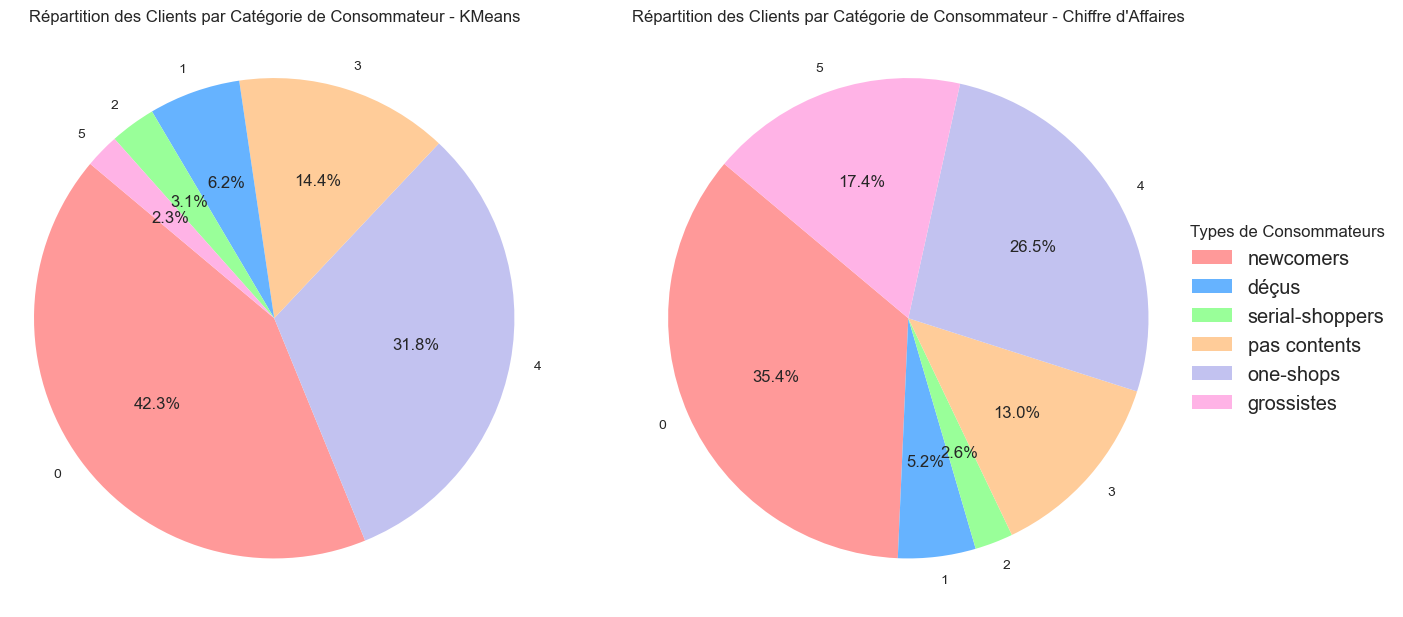

In [36]:
# Fusion des DataFrames et suppression de la colonne 'customer_id'
olist = pd.concat([olist, kmeans], axis=1)
olist.drop(columns=['customer_id'], inplace=True)

# Calcul des pourcentages pour les catégories de KMeans et le chiffre d'affaires
percentages_kmeans = (pd.Series(kmeans['Cluster kmeans']).value_counts() 
                       / len(kmeans['Cluster kmeans']) * 100)
percentages_turnover = (pd.Series(olist.drop(columns=['latest_purchase'])
                                  .groupby(['Cluster kmeans']).sum()['total'])
                        / sum(olist['total']) * 100)

# Définition des labels et couleurs pour les graphiques
labels_kmeans = {
    '0': 'newcomers',
    '1': 'déçus',
    '2': 'serial-shoppers',
    '3': 'pas contents',
    '4': 'one-shops',
    '5': 'grossistes'}
colors = {
    '0': '#ff9999',
    '1': '#66b3ff',
    '2': '#99ff99',
    '3': '#ffcc99',
    '4': '#c2c2f0',
    '5': '#ffb3e6'}

# Création des listes de couleurs pour les graphiques
colors_kmeans = [colors[i] for i in percentages_kmeans.index]
colors_turnover = [colors[i] for i in percentages_turnover.index]

# Création des graphiques
plt.figure(figsize=(15, 7.5))

# Premier subplot: Répartition des clients par catégorie de consommateur - KMeans
plt.subplot(1, 2, 1)
plt.pie(
    percentages_kmeans,
    labels=percentages_kmeans.index.astype(str),
    autopct='%1.1f%%',
    startangle=140,
    colors=colors_kmeans)
plt.title('Répartition des Clients par Catégorie de Consommateur - KMeans')
plt.axis('equal')
plt.grid()

# Deuxième subplot: Répartition des clients par catégorie de consommateur - Chiffre d'Affaires
plt.subplot(1, 2, 2)
pie_turnover = plt.pie(
    percentages_turnover,
    labels=percentages_turnover.index.astype(str),
    autopct='%1.1f%%',
    startangle=140,
    colors=colors_turnover
)
plt.legend(
    pie_turnover[0],
    [labels_kmeans[key] for key in percentages_turnover.index],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title="Types de Consommateurs",
    fontsize='large'
)
plt.title("Répartition des Clients par Catégorie de Consommateur - Chiffre d'Affaires")
plt.axis('equal')
plt.grid()

plt.show()

Les information importantes à retenir de ces graphiques se résument de la manière suivante:
- les Newcomers et les One-shop dominent en termes de nombre de clients, mais leur contribution au chiffre d'affaires est moins marquée, surtout pour les newcomers. Ces groupes sont potentiellement constitués de clients occasionnels ou peu engagés, nécessitant des stratégies pour augmenter leur valeur à vie (LTV).
- Les Grossistes sont extrêmement précieux, malgré leur faible nombre, en raison de leur contribution élevée au chiffre d'affaires. Il est ainsi crucial de fidéliser ces clients avec des offres et des services sur mesure.
- Les Pas-Contents ont un rôle ambigu : ils représentent une part notable du chiffre d'affaires, mais leur insatisfaction pourrait conduire à des pertes futures si leurs préoccupations ne sont pas adressées.
- Les Déçus et les Serial-Shoppers constituent des groupes à l'importance restreinte et à l'impact limité. Pour autant, des stratégies pour conserver la régularité des serial-shoppers ne peuvent qu'être bénéfiques.

En conclusion, ces visualisations mettent en lumière l'importance de comprendre non seulement la taille de chaque segment de clients, mais aussi leur impact financier, afin de développer des stratégies adaptées pour maximiser la valeur de chaque groupe.

Nous allons maintenant, pour la dernière partie de ce chapitre, nous intéresser brièvement à la répartition géographique des clients selon leur cluster KMeans sur une carte, où chaque point correspond à un client, et les couleurs représentent les différentes catégories de consommateurs:

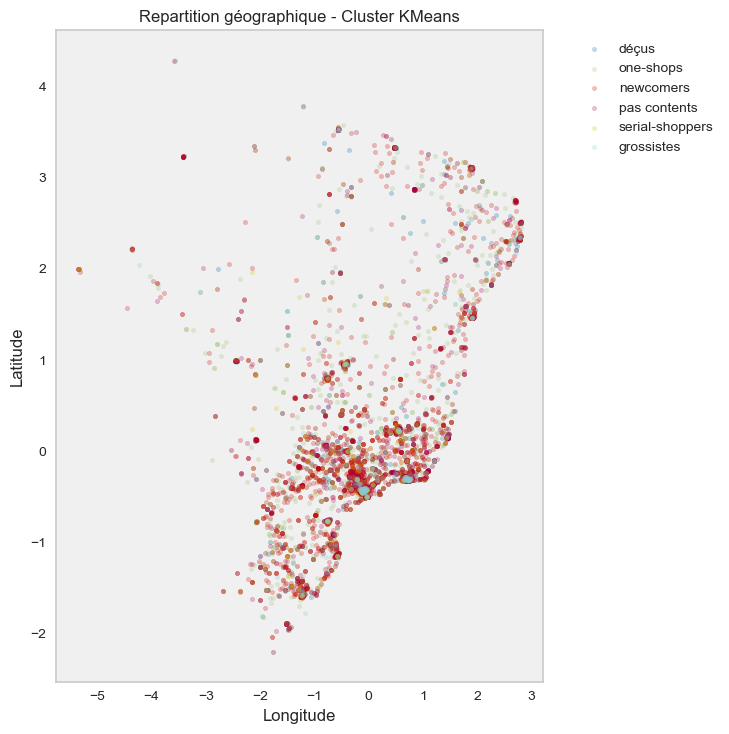

In [37]:
plt.figure(figsize=(7.5, 7.5))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Repartition géographique - Cluster KMeans")

# Création d'une liste pour les handles de la légende
legend_handles_kmeans = []

# Définition de la couleur de fond de la grille
plt.gca().set_facecolor('#F0F0F0')

# Boucle pour créer les scatter plots pour chaque cluster KMeans
for i in standard['Cluster kmeans'].unique():
    handle = plt.scatter(
        standard['long'][standard['Cluster kmeans'] == i],
        standard['latt'][standard['Cluster kmeans'] == i],
        alpha=0.25,
        s=10,
        label=f'{i}')
    legend_handles_kmeans.append(handle)
    
# Création des labels pour la légende en fonction des clusters
legend_labels_kmeans = [labels_kmeans[str(key)] for key in standard['Cluster kmeans'].unique()]

# Ajout de la légende au graphique
plt.legend(
    handles=legend_handles_kmeans,
    labels=legend_labels_kmeans,
    bbox_to_anchor=(1.05, 1))
plt.grid()
plt.tight_layout()
plt.show()

La répartition géographique des consommateurs par catégorie permet d'observer les points suivants :

- Les Newcomers sont largement répartis dans toutes les régions, mais particulièrement concentrés dans les zones de forte densité. Cela pourrait indiquer que ce groupe est composé de clients qui habitent principalement dans des zones urbaines où l'activité économique est plus intense.
- Les One-Shop sont également répandus, mais avec une densité légèrement inférieure par rapport aux newcomers. Leur répartition pourrait refléter un comportement d'achat occasionnel ou sporadique.
- Les Pas-Contents sont présents, mais semblent moins concentrés, ce qui pourrait indiquer une certaine diversité dans les lieux de résidence des clients insatisfaits.
- Les Déçus et les Serial-Shoppers sont peu nombreuses et dispersées. Les serial-shoppers semblent légèrement plus concentrés dans les zones urbaines, ce qui peut indiquer une population de clients réguliers mais de petite taille.
- Les Grossistes sont également épars, mais leur présence dans des zones spécifiques indiquent des régions où le commerce en gros est plus courant ou où les clients passent des commandes de grande envergure.

D'un manière générale, comme vu lors de l'analyse exploratoire du précédent notebook, la carte montre une concentration marquée des clients dans une région spécifique, celle qui englobe les 2 centre urbains de très loin les plus importants du pays : Sao Paulo et Rio de Janeiro. Les clients des clusters Newcomers et One-Shop dominent clairement cette zone. Il existe dès lors une fort probable corrélation entre la densité des points et les types de consommateurs, ce qui suggère que les stratégies de marketing et de vente pourraient être régionalisées pour mieux cibler ces segments.


# Conclusion<a name=14 ></a>

L'analyse des données client via diverses méthodes de clustering, à partir duquel nous avons fait le choix de l'algorithme KMeans, a permis d'obtenir une segmentation fine et informative des consommateurs. Ces méthodes ont révélé des insights cruciaux sur les différents comportements d'achat et les caractéristiques géographiques des clients, offrant ainsi une base solide pour l'élaboration de stratégies marketing et commerciales plus ciblées.

Le choix du modèle KMeans avec 6 clusters distincts s'est avéré pertinent, comme l'ont démontré les analyses visuelles et statistiques effectuées. Les clusters ont été interprétés en catégories de consommateurs bien définies : newcomers, déçus, serial-shoppers, pas contents, one-shops, et grossistes. Cette segmentation a mis en lumière des tendances claires, notamment une majorité de clients classés comme newcomers et one-shops, ce qui souligne et confirme la prédominance des acheteurs occasionnels dans cette base de données.

Les boxplots par cluster ont révélé des disparités significatives entre les différents segments, en termes de montant total des achats, de fréquence des achats, de récence des achats, et de satisfaction. Par exemple, les newcomers se caractérisent par une récence d'achat récente mais avec un volume d'achat encore faible, tandis que les serial-shoppers montrent une régularité et une fréquence d'achat élevées.

Les graphiques en secteurs ont confirmé la prépondérance des newcomers dans la base de clients, tant en nombre qu'en chiffre d'affaires. Cependant, bien que représentant un pourcentage moindre de la base totale, les serial-shoppers et les grossistes jouent un rôle clé dans le chiffre d'affaires global, suggérant l'importance de fidéliser et de cultiver ces segments pour maximiser les revenus.

La carte géographique des clusters, quant à elle, a montré une concentration des clients dans certaines zones spécifiques, notamment urbaines, avec une forte représentation des newcomers. Cette concentration géographique pourrait être exploitée pour adapter les stratégies de marketing régionalisées et optimiser les ressources en fonction des caractéristiques locales des consommateurs.

Cette segmentation approfondie des clients permet d'élaborer des stratégies marketing plus ciblées, plus personnalisées et plus efficaces. Quelques exemples de stratégie peuvent être données ici:
- Newcomers et One-Shops : Ces segments devraient être ciblés par des campagnes de rétention pour les convertir en clients réguliers.
- Déçus et Pas Contents : Des actions spécifiques pour comprendre et améliorer leur satisfaction pourraient transformer ces clients en ambassadeurs de la marque.
- Serial-Shoppers et Grossistes : Ces segments nécessitent des programmes de fidélisation sur mesure pour maximiser leur valeur à long terme.

En somme, les résultats de cette analyse permettent de mieux comprendre la composition de la clientèle et d'orienter les efforts commerciaux vers les segments les plus prometteurs, tout en optimisant les ressources disponibles. Les entreprises qui exploitent efficacement ces insights pourront non seulement améliorer leur satisfaction client, mais également accroître leur chiffre d'affaires et leur part de marché dans un environnement de plus en plus compétitif.